# Q1 Problem of Stock Prediction

## Part-1:  RNN

In [0]:
import pandas as pd
import numpy as np

In [0]:
from sklearn.preprocessing import MinMaxScaler

In [0]:
url = 'https://raw.githubusercontent.com/20188202010/SMAI_ASSIGNMENTS/master/GoogleStocks.csv?token=AonRVlOgsC5Fq9KbbuBNhikeTv0sqEz7ks5csX4FwA%3D%3D'

In [5]:
dataset = pd.read_csv(url, thousands=',')
# dataset = pd.read_csv('../input_data/GoogleStocks.csv', thousands=',')
print "dataset.shape: ",dataset.shape, "cols: ", dataset.columns
dataset['date'] =pd.to_datetime(dataset.date)
dataset = dataset.sort_values(by='date')
dataset.head()

dataset.shape:  (756, 6) cols:  Index([u'date', u'close', u'volume', u'open', u'high', u'low'], dtype='object')


,date,close,volume,open,high,low
755,2016-03-28,733.53,1300817.0,736.79,738.99,732.50
754,2016-03-29,744.77,1902254.0,734.59,747.25,728.76
753,2016-03-30,750.53,1782278.0,750.10,757.88,748.74
752,2016-03-31,744.95,1718638.0,749.25,750.85,740.94
751,2016-04-01,749.91,1576240.0,738.60,750.34,737.00


 The features you will be using are:
 - Average of the low and high of the Google Inc.  stock for the day.
 - Volume of the stocks traded for the day.
 <br>These will be used by you for predicting stock prices.  

In [0]:
features = ['Average','Volume']
target = 'open'

In [0]:
def findMean(df, col1, col2, new_col):
  
    df[new_col] = df[[col1, col2]].mean(axis=1)
    
    return df[new_col]

In [0]:
average_col = findMean(dataset, 'low', 'high', 'avg')

In [0]:
feature_set = dataset[['volume','avg']].values
open_set = dataset[target]

In [0]:
def divideTimestamp(df_x, ts, df_y=None, pred=False):
    x_train, y_train = [], []
    x_rows = df_x.shape[0]
    for i in range(ts, x_rows):
        x_train.append(df_x[i-ts:i, :])
        if pred==False:
          y_train.append(df_y[i])
        
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    
    return x_train, y_train

In [0]:
def makeInput(df_x, ts, df_y=None, flag=False):
  global features
  n = len(features)
  X,Y = divideTimestamp(df_x, ts, df_y, flag)
  
  X = np.reshape(X, (X.shape[0], X.shape[1], n)) #batchsize, timesteps, input features

  
  return X, Y

In [0]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten

In [0]:
def RNNModel(X, Y, num_units, num_layers, optimizer, epochs, batchsize):

  global features
  n = len(features)
  regressor = Sequential()

  regressor.add(LSTM(units = num_units, return_sequences = True, input_shape = (X.shape[1], n)))
  regressor.add(Dropout(rate = 1-0.2))
  
  regressor.add(LSTM(units = num_units, return_sequences = True))
  regressor.add(Dropout(rate = 1-0.2))
  
  if num_layers == 3:
    regressor.add(LSTM(units = num_units, return_sequences = True))
    regressor.add(Dropout(rate = 1-0.2))
  
  regressor.add(Flatten())
  
  regressor.add(Dense(units = 1))
  
  regressor.compile(optimizer = optimizer, loss = 'mean_squared_error')
  
  regressor.fit(X, Y, epochs = epochs, batch_size = batchsize)
  
  return regressor

In [0]:
def predict(x_attr, y_attr, regressor, ts, sc):
  
  inputs = x_attr[len(x_attr) - len(y_attr) - ts:,:]
  
  print "predict: ",
  X_test, none_ = makeInput(inputs, ts, flag=True)
  predicted_stock_price = regressor.predict(X_test)
  predicted_stock_price = sc.inverse_transform(predicted_stock_price)

  return predicted_stock_price

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plotGraph(actual_arr, pred_arr, title, sc):
  actual_arr = sc.inverse_transform(actual_arr)
  fig, axes = plt.subplots(figsize=(10, 4))
  axes.plot(pred_arr, color = 'm', label = 'Pred Open')
  axes.plot(actual_arr, color = 'g', label = 'Actual Open')
  axes.grid(True)
  axes.set_xlabel('Time')
  axes.set_ylabel('Open')
  axes.legend(loc='best')
  
  axes.set_title(title+' Open vs Time') 
  fig.savefig(title)


In [0]:
def testModel(attributes, target_col, num_layers,num_units,timestep,optimizer, epochs, batchsize ):

  sc = MinMaxScaler(feature_range = (0, 1))
  attributes = sc.fit_transform(attributes)
  target_col = target_col.reshape(-1,1)
  target_col = sc.fit_transform(target_col)
  
  train, validate = np.split(attributes, [int(.8*len(attributes))])
  train_y, validate_y = np.split(target_col, [int(.8*len(target_col))])
  
  
  X, Y = makeInput(train, timestep, df_y=train_y)
  model = RNNModel(X,Y,num_units, num_layers, optimizer, epochs, batchsize)
  prediction = predict(attributes, validate, model, timestep, sc)

  title = "("+str(num_layers)+" , "+str(num_units)+" , "+str(timestep)+")"
  plotGraph(validate_y, prediction, title, sc)
  return prediction

### 20 TIMESTEPS

#### Two Layer

**1. 2 layers 30 hidden nodes 20 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/125
584/584 [==============================] - 3s 4ms/step - loss: 0.0787
Epoch 2/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0236
Epoch 3/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0183
Epoch 4/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0153
Epoch 5/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0141
Epoch 6/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0117
Epoch 7/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0108
Epoch 8/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0104
Epoch 9/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0102
Epoch 10/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0101
Epoch 11/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0088
Epoch 12/125
584/584 [==============================] - 1s 1ms/step - loss: 0.0078
Epoch 13/125


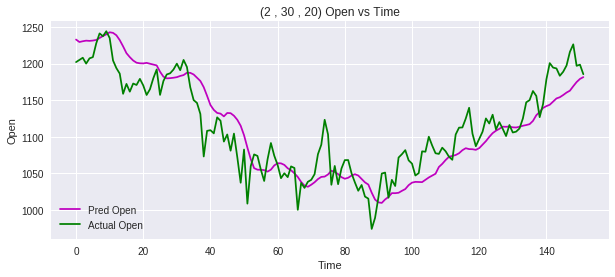

In [21]:
prediction = testModel(feature_set, open_set, 2, 30, 20, 'adam', 125, 16) 

**2. 2 layers 50 hidden nodes 20 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/150
584/584 [==============================] - 2s 4ms/step - loss: 0.1278
Epoch 2/150
584/584 [==============================] - 0s 617us/step - loss: 0.0372
Epoch 3/150
584/584 [==============================] - 0s 607us/step - loss: 0.0247
Epoch 4/150
584/584 [==============================] - 0s 631us/step - loss: 0.0204
Epoch 5/150
584/584 [==============================] - 0s 624us/step - loss: 0.0178
Epoch 6/150
584/584 [==============================] - 0s 627us/step - loss: 0.0159
Epoch 7/150
584/584 [==============================] - 0s 629us/step - loss: 0.0156
Epoch 8/150
584/584 [==============================] - 0s 613us/step - loss: 0.0127
Epoch 9/150
584/584 [==============================] - 0s 628us/step - loss: 0.0110
Epoch 10/150
584/584 [==============================] - 0s 634us/step - loss: 0.0121
Epoch 11/150
584/584 [==============================] - 0s 610us/step - loss: 0.0119
Epoch 12/150
584/584 [==============================] - 0s 628us/step - loss

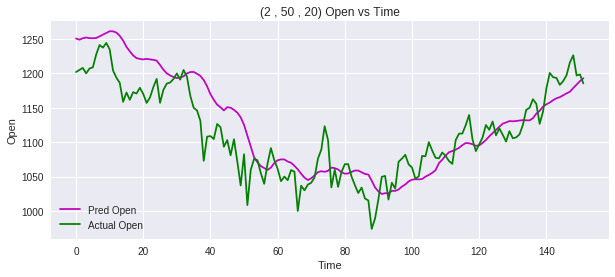

In [22]:
prediction = testModel(feature_set, open_set, 2, 50, 20, 'adam', 150, 64) 

**3. 2 layers 80 hidden nodes 20 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/20
584/584 [==============================] - 3s 5ms/step - loss: 0.1897
Epoch 2/20
584/584 [==============================] - 1s 863us/step - loss: 0.0474
Epoch 3/20
584/584 [==============================] - 1s 895us/step - loss: 0.0324
Epoch 4/20
584/584 [==============================] - 1s 870us/step - loss: 0.0337
Epoch 5/20
584/584 [==============================] - 1s 891us/step - loss: 0.0170
Epoch 6/20
584/584 [==============================] - 1s 890us/step - loss: 0.0207
Epoch 7/20
584/584 [==============================] - 1s 881us/step - loss: 0.0141
Epoch 8/20
584/584 [==============================] - 1s 862us/step - loss: 0.0145
Epoch 9/20
584/584 [==============================] - 1s 869us/step - loss: 0.0126
Epoch 10/20
584/584 [==============================] - 0s 842us/step - loss: 0.0118
Epoch 11/20
584/584 [==============================] - 1s 866us/step - loss: 0.0097
Epoch 12/20
584/584 [==============================] - 1s 876us/step - loss: 0.0093
Epo

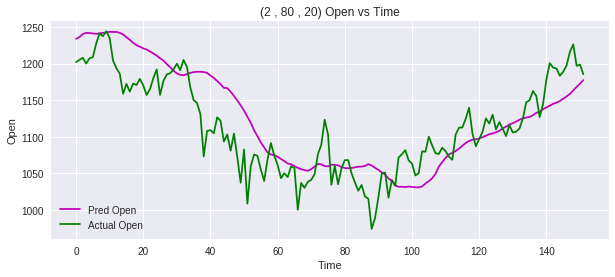

In [23]:
prediction = testModel(feature_set, open_set, 2, 80, 20, 'adam', 20, 128) 

#### Three Layer

**4. 3 layers 30 hidden nodes 20 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/100
584/584 [==============================] - 5s 8ms/step - loss: 0.1435
Epoch 2/100
584/584 [==============================] - 0s 761us/step - loss: 0.0523
Epoch 3/100
584/584 [==============================] - 0s 756us/step - loss: 0.0428
Epoch 4/100
584/584 [==============================] - 0s 805us/step - loss: 0.0278
Epoch 5/100
584/584 [==============================] - 0s 769us/step - loss: 0.0250
Epoch 6/100
584/584 [==============================] - 0s 766us/step - loss: 0.0231
Epoch 7/100
584/584 [==============================] - 0s 752us/step - loss: 0.0200
Epoch 8/100
584/584 [==============================] - 0s 744us/step - loss: 0.0184
Epoch 9/100
584/584 [==============================] - 0s 760us/step - loss: 0.0182
Epoch 10/100
584/584 [==============================] - 0s 763us/step - loss: 0.0163
Epoch 11/100
584/584 [==============================] - 0s 750us/step - loss: 0.0164
Epoch 12/100
584/584 [==============================] - 0s 766us/step - loss

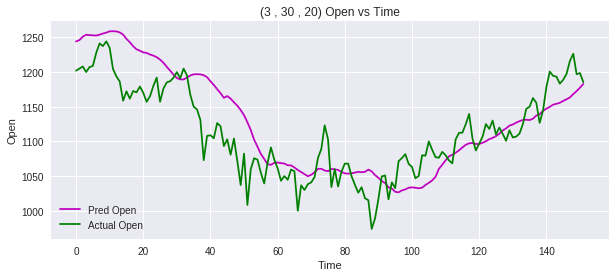

In [26]:
prediction = testModel(feature_set, open_set, 3, 30, 20, 'adam', 100, 64) 

**5. 3 layers 50 hidden nodes 20 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/75
584/584 [==============================] - 6s 10ms/step - loss: 0.1021
Epoch 2/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0276
Epoch 3/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0178
Epoch 4/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0151
Epoch 5/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0132
Epoch 6/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0154
Epoch 7/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0122
Epoch 8/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0111
Epoch 9/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 10/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0091
Epoch 11/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0097
Epoch 12/75
584/584 [==============================] - 1s 1ms/step - loss: 0.0089
Epoch 13/75
584/584 [===

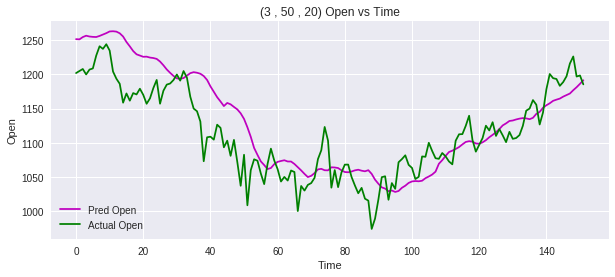

In [27]:
prediction = testModel(feature_set, open_set, 3, 50, 20, 'adam', 75, 32) 

**6. 3 layers 80 hidden nodes 20 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/50
584/584 [==============================] - 6s 11ms/step - loss: 0.2064
Epoch 2/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0564
Epoch 3/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0415
Epoch 4/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0412
Epoch 5/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0215
Epoch 6/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0215
Epoch 7/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0171
Epoch 8/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0127
Epoch 9/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0147
Epoch 10/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0131
Epoch 11/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0124
Epoch 12/50
584/584 [==============================] - 1s 1ms/step - loss: 0.0106
Epoch 13/50
584/584 [===

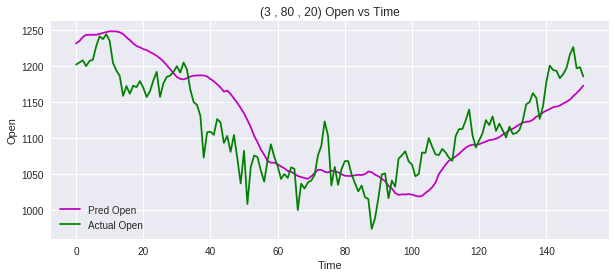

In [28]:
prediction = testModel(feature_set, open_set, 3, 80, 20, 'adam', 50, 128) 

### 50 TIMESTEPS

#### Two Layer

**7. 2 layers 30 hidden nodes 50 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/200
554/554 [==============================] - 8s 14ms/step - loss: 0.0905
Epoch 2/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0293
Epoch 3/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0195
Epoch 4/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0155
Epoch 5/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0169
Epoch 6/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0129
Epoch 7/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0115
Epoch 8/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0112
Epoch 9/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0096
Epoch 10/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0102
Epoch 11/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0094
Epoch 12/200
554/554 [==============================] - 1s 2ms/step - loss: 0.0085
Epoch 13/200

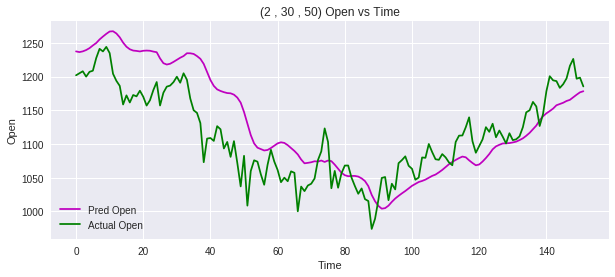

In [29]:
prediction = testModel(feature_set, open_set, 2, 30, 50, 'adam', 200, 32) 

**8. 2 layers 50 hidden nodes 50 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/80
554/554 [==============================] - 9s 17ms/step - loss: 0.0356
Epoch 2/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0111
Epoch 3/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0097
Epoch 4/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0089
Epoch 5/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0078
Epoch 6/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0073
Epoch 7/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0064
Epoch 8/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0067
Epoch 9/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0070
Epoch 10/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0057
Epoch 11/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0054
Epoch 12/80
554/554 [==============================] - 4s 7ms/step - loss: 0.0049
Epoch 13/80
554/554 [===

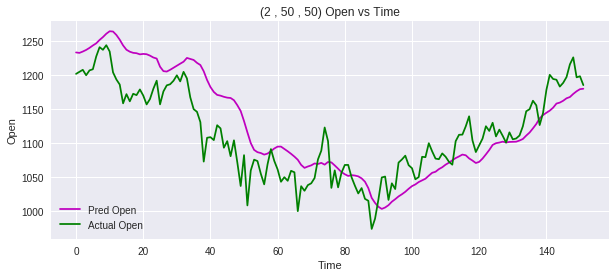

In [30]:
prediction = testModel(feature_set, open_set, 2, 50, 50, 'adam', 80, 8)

**9. 2 layers 80 hidden nodes 50 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/50
554/554 [==============================] - 8s 15ms/step - loss: 0.0437
Epoch 2/50
554/554 [==============================] - 2s 5ms/step - loss: 0.0125
Epoch 3/50
554/554 [==============================] - 2s 4ms/step - loss: 0.0100
Epoch 4/50
554/554 [==============================] - 2s 4ms/step - loss: 0.0084
Epoch 5/50
554/554 [==============================] - 3s 5ms/step - loss: 0.0076
Epoch 6/50
554/554 [==============================] - 2s 4ms/step - loss: 0.0067
Epoch 7/50
554/554 [==============================] - 2s 4ms/step - loss: 0.0058
Epoch 8/50
554/554 [==============================] - 2s 4ms/step - loss: 0.0056
Epoch 9/50
554/554 [==============================] - 2s 4ms/step - loss: 0.0058
Epoch 10/50
554/554 [==============================] - 2s 4ms/step - loss: 0.0064
Epoch 11/50
554/554 [==============================] - 2s 4ms/step - loss: 0.0062
Epoch 12/50
554/554 [==============================] - 2s 4ms/step - loss: 0.0050
Epoch 13/50
554/554 [===

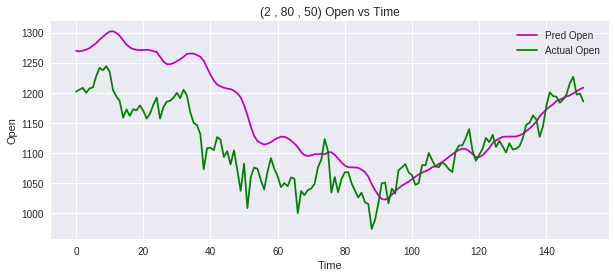

In [31]:
prediction = testModel(feature_set, open_set, 2, 80, 50, 'adam', 50, 16) 

#### Three Layer

**10. 3 layers 30 hidden nodes 50 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/60
554/554 [==============================] - 9s 16ms/step - loss: 0.1155
Epoch 2/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0262
Epoch 3/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0180
Epoch 4/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0147
Epoch 5/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0150
Epoch 6/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0116
Epoch 7/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0108
Epoch 8/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0106
Epoch 9/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0099
Epoch 10/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0102
Epoch 11/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0096
Epoch 12/60
554/554 [==============================] - 2s 3ms/step - loss: 0.0092
Epoch 13/60
554/554 [===

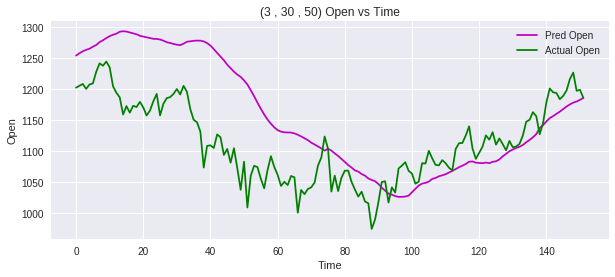

In [32]:
prediction = testModel(feature_set, open_set, 3, 30, 50, 'adam', 60, 32)

**11. 3 layers 50 hidden nodes 50 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/30
554/554 [==============================] - 9s 15ms/step - loss: 0.1052
Epoch 2/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0465
Epoch 3/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0251
Epoch 4/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0167
Epoch 5/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0158
Epoch 6/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0126
Epoch 7/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0125
Epoch 8/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0116
Epoch 9/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0111
Epoch 10/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0113
Epoch 11/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0097
Epoch 12/30
554/554 [==============================] - 1s 2ms/step - loss: 0.0093
Epoch 13/30
554/554 [===

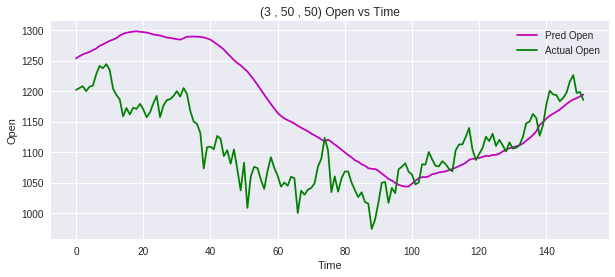

In [33]:
prediction = testModel(feature_set, open_set, 3, 50, 50, 'adam', 30, 64) 

**12. 3 layers 80 hidden nodes 50 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/25
554/554 [==============================] - 10s 18ms/step - loss: 0.0613
Epoch 2/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0157
Epoch 3/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0098
Epoch 4/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0086
Epoch 5/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0093
Epoch 6/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0088
Epoch 7/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0082
Epoch 8/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0084
Epoch 9/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0083
Epoch 10/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0063
Epoch 11/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0062
Epoch 12/25
554/554 [==============================] - 2s 4ms/step - loss: 0.0064
Epoch 13/25
554/554 [==

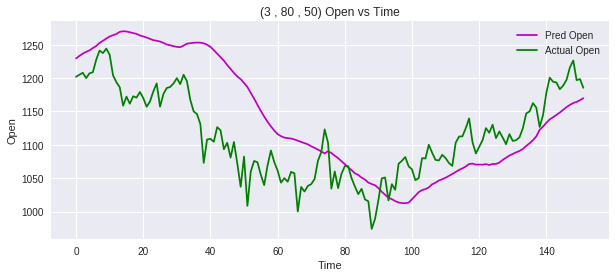

In [34]:
prediction = testModel(feature_set, open_set, 3, 80, 50, 'adam', 25, 32) 

### 75 TIMESTEPS

#### Two Layer

**13. 2 layers 30 hidden nodes 75 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/100
529/529 [==============================] - 9s 17ms/step - loss: 0.0788
Epoch 2/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0276
Epoch 3/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0237
Epoch 4/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0188
Epoch 5/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0125
Epoch 6/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0150
Epoch 7/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0136
Epoch 8/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0120
Epoch 9/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0117
Epoch 10/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0101
Epoch 11/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0100
Epoch 12/100
529/529 [==============================] - 1s 3ms/step - loss: 0.0095
Epoch 13/100

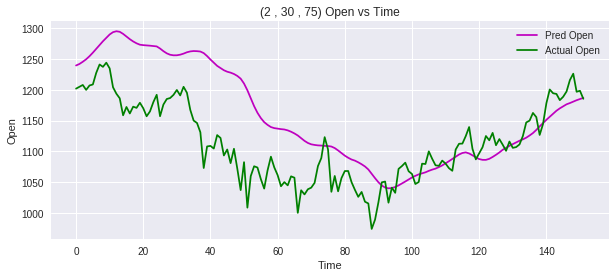

In [35]:
prediction = testModel(feature_set, open_set, 2, 30, 75, 'adam', 100, 32)

**14. 2 layers 50 hidden nodes 75 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/50
529/529 [==============================] - 9s 17ms/step - loss: 0.0929
Epoch 2/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0323
Epoch 3/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0178
Epoch 4/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0153
Epoch 5/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0121
Epoch 6/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0132
Epoch 7/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0117
Epoch 8/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0100
Epoch 9/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0113
Epoch 10/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0098
Epoch 11/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0080
Epoch 12/50
529/529 [==============================] - 1s 2ms/step - loss: 0.0090
Epoch 13/50
529/529 [===

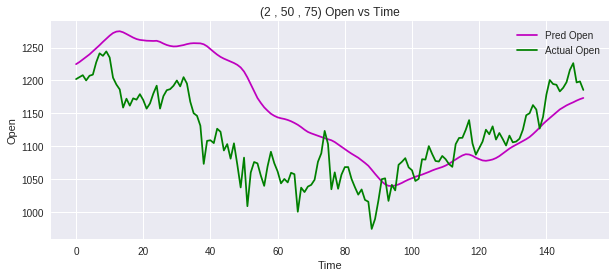

In [36]:
prediction = testModel(feature_set, open_set, 2, 50, 75, 'adam', 50, 64) 

**15. 2 layers 80 hidden nodes 75 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/30
529/529 [==============================] - 12s 23ms/step - loss: 0.0430
Epoch 2/30
529/529 [==============================] - 4s 7ms/step - loss: 0.0132
Epoch 3/30
529/529 [==============================] - 4s 7ms/step - loss: 0.0103
Epoch 4/30
529/529 [==============================] - 3s 7ms/step - loss: 0.0109
Epoch 5/30
529/529 [==============================] - 4s 7ms/step - loss: 0.0079
Epoch 6/30
529/529 [==============================] - 4s 7ms/step - loss: 0.0075
Epoch 7/30
529/529 [==============================] - 4s 7ms/step - loss: 0.0071
Epoch 8/30
529/529 [==============================] - 4s 7ms/step - loss: 0.0061
Epoch 9/30
529/529 [==============================] - 3s 7ms/step - loss: 0.0069
Epoch 10/30
529/529 [==============================] - 3s 7ms/step - loss: 0.0067
Epoch 11/30
529/529 [==============================] - 3s 7ms/step - loss: 0.0056
Epoch 12/30
529/529 [==============================] - 3s 7ms/step - loss: 0.0054
Epoch 13/30
529/529 [==

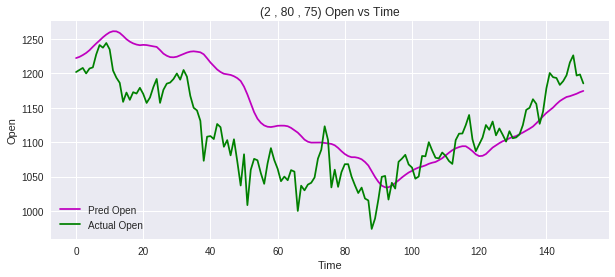

In [37]:
prediction = testModel(feature_set, open_set, 2, 80, 75, 'adam', 30, 16) 

#### Three Layer

**16. 3 layers 30 hidden nodes 75 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/30
529/529 [==============================] - 11s 22ms/step - loss: 0.0976
Epoch 2/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0376
Epoch 3/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0207
Epoch 4/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0174
Epoch 5/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0155
Epoch 6/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0125
Epoch 7/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0135
Epoch 8/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0133
Epoch 9/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0102
Epoch 10/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0108
Epoch 11/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0100
Epoch 12/30
529/529 [==============================] - 2s 4ms/step - loss: 0.0100
Epoch 13/30
529/529 [==

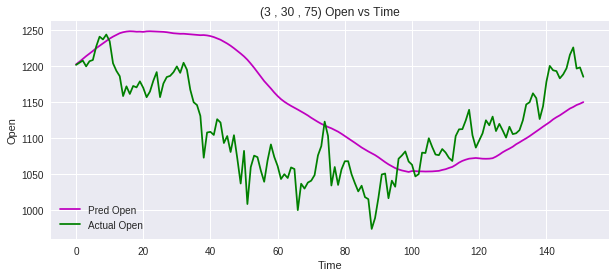

In [38]:
prediction = testModel(feature_set, open_set, 3, 30, 75, 'adam', 30, 32)

**17. 3 layers 50 hidden nodes 75 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/50
529/529 [==============================] - 12s 23ms/step - loss: 0.0689
Epoch 2/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0181
Epoch 3/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0132
Epoch 4/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0114
Epoch 5/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0110
Epoch 6/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0096
Epoch 7/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0094
Epoch 8/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0088
Epoch 9/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0091
Epoch 10/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0087
Epoch 11/50
529/529 [==============================] - 3s 5ms/step - loss: 0.0078
Epoch 12/50
529/529 [==============================] - 2s 5ms/step - loss: 0.0069
Epoch 13/50
529/529 [==

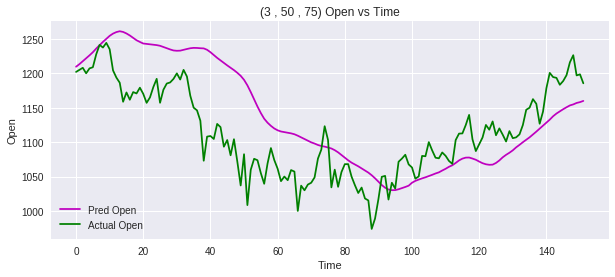

In [39]:
prediction = testModel(feature_set, open_set, 3, 50, 75, 'adam', 50, 32) 

**18. 3 layers 80 hidden nodes 75 timesteps**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Epoch 1/50
529/529 [==============================] - 16s 29ms/step - loss: 0.0477
Epoch 2/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0165
Epoch 3/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0103
Epoch 4/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0080
Epoch 5/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0082
Epoch 6/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0074
Epoch 7/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0074
Epoch 8/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0081
Epoch 9/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0067
Epoch 10/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0071
Epoch 11/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0062
Epoch 12/50
529/529 [==============================] - 5s 10ms/step - loss: 0.0053
Epoch 13/50


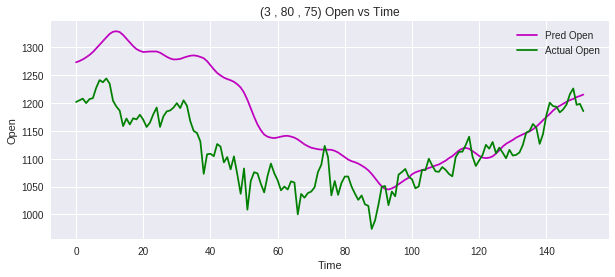

In [40]:
prediction = testModel(feature_set, open_set, 3, 80, 75, 'adam', 50, 16) 